<a href="https://colab.research.google.com/github/ykitaguchi77/Colab_Scripts/blob/master/ResNet%E3%81%AB%E5%B1%A4%E3%82%92%E8%BF%BD%E5%8A%A0%E3%81%99%E3%82%8B%E3%81%A8%E3%81%8D%E3%81%AE%E6%9B%B8%E3%81%8D%E6%96%B9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#PyTorch : Tutorial 初級 : 転移学習チュートリアル

http://torch.classcat.com/2018/04/29/pytorch-tutorial-transfer-learning/


#自作データ、Early stopping

In [ ]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

#Advanced Pytorchから
import glob
import os.path as osp
import random
import numpy as np
import json
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models, transforms

#ukiyoeから
import matplotlib.pyplot as plt

plt.ion()   # interactive mode

#Google driveのデータをマウント

In [ ]:

'''
grav: 甲状腺眼症
cont: コントロール
黒の空白を挿入することにより225px*225pxの画像を生成、RESNETを用いて転移学習
－－－－－－－－－－－－－－
アップデータするデータの構造
gravcont.zip ----data---- hymenoptera_data----train
                         |            |    |--val
                         |            |-- imagenet_class_index.json
                         |            |-- __init__.py
                         |            |-- bennetts-wallabu-01.jpg
                         |            |-- goldenretriever-3724972_640.jpg
                         |
                         |-- utils---- __pycache__---- __init__.cpython-36.pyc
                                       |                        |-- dataloader_image_classification.cpython-36.pyc
                                       |-- __init__.py
                                       |-- dataloader_image_classification.py
－－－－－－－－－－－－－－
'''                                     

#google driveをcolabolatoryにマウント
from google.colab import drive
drive.mount('/content/drive')

#Advanced.zipを解凍

!date -R
!unzip -qq drive/My\ Drive/gravcont.zip
!date -R
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Fri, 08 Jan 2021 04:37:08 +0000
unzip:  cannot find or open drive/My Drive/gravcont.zip, drive/My Drive/gravcont.zip.zip or drive/My Drive/gravcont.zip.ZIP.
Fri, 08 Jan 2021 04:37:08 +0000
checkpoint.pt  drive  sample_data


#データをロードする
データをロードするために torchvision と torch.utils.data パッケージを使用します。今日解いていく問題はアリ (= ants) とハチ (= bees) を分類するモデルを訓練することです。アリとハチのためにおよそ 120 訓練画像を持ちます。各クラスのために 75 検証画像があります。通常は、スクラッチから訓練される場合、これは一般化するには非常に小さいデータセットです。私達は転移学習を使用していますので、合理的に上手く一般化することができるはずです。

このデータセットは imagenet の非常に小さなサブセットです。

In [ ]:
# 入力画像の前処理をするクラス
# 訓練時と推論時で処理が異なる

"""
    画像の前処理クラス。訓練時、検証時で異なる動作をする。
    画像のサイズをリサイズし、色を標準化する。
    訓練時はRandomResizedCropとRandomHorizontalFlipでデータオーギュメンテーションする。


    Attributes
    ----------
    resize : int
        リサイズ先の画像の大きさ。
    mean : (R, G, B)
        各色チャネルの平均値。
    std : (R, G, B)
        各色チャネルの標準偏差。
"""

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.5,1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/drive/My Drive/Deep_learning/gravcont_seed_20200815'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=20,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



print(class_names)
k=0
for i in class_names:
    print(class_names[k]+"_train:"+str(len(os.listdir(path=data_dir + '/train/'+class_names[k]))))
    k+=1
k=0
for i in class_names:
    print(class_names[k]+"_val:"+str(len(os.listdir(path=data_dir + '/val/'+class_names[k]))))
    k+=1

print("training data set_total："+ str(len(image_datasets['train'])))
print("validating data set_total："+str(len(image_datasets['val'])))

['cont', 'grav']
cont_train:266
grav_train:266
cont_val:67
grav_val:67
training data set_total：532
validating data set_total：134


#少数の画像を可視化する

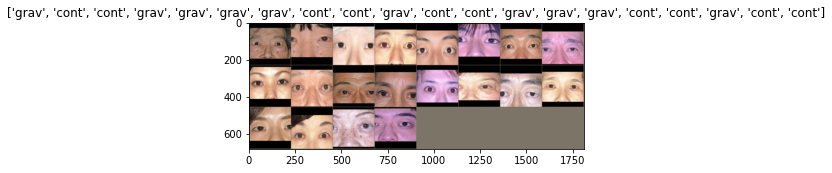

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

#Define the Early Stopping Class

In [ ]:
import numpy as np
import torch

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

#モデルを訓練する
さて、モデルを訓練するための一般的な関数を書きましょう。ここで、次を示します :

学習率をスケジューリングする
ベスト・モデルをセーブする
以下で、パラメータ scheduler は torch.optim.lr_scheduler からの LR scheduler オブジェクトです。

In [ ]:
def train_model(model, criterion, optimizer, scheduler, patience, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # to track the training loss as the model trains
    train_loss = []
    # to track the validation loss as the model trains
    valid_loss = []


    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=patience, verbose=True)

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase] 
            
            # record train_loss and valid_loss
            if phase == 'train':
                train_loss.append(epoch_loss)
            if phase == 'val':
                valid_loss.append(epoch_loss)
            #print(train_loss)
            #print(valid_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))


            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
      
      # early_stopping needs the validation loss to check if it has decresed, 
      # and if it has, it will make a checkpoint of the current model
        if phase == 'val':    
            early_stopping(epoch_loss, model)
                
            if early_stopping.early_stop:
                print("Early stopping")
                break
        print()


    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_loss, valid_loss

#モデル予測を可視化する
少数の画像のための予測を表示するための一般的な関数。

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

#convnet を再調整する
事前訓練されたモデルをロードして最後の完全結合層をリセットします。

In [ ]:
model_ft = models.resnet50(pretrained=False)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

#GPU使用
model_ft = model_ft.to(device)

#損失関数を定義
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

#ResNetに層を追加するときの書き方

In [ ]:
class Resnet(nn.Module):
  def __init__(self):
    super(Resnet,self).__init__()
    resnet = models.resnet50(pretrained=True)
    self.resnet = nn.Sequential(*list(resnet.children())[:-2])
    self.maxpool = nn.MaxPool2d(kernel_size=7)
    self.fc = nn.Linear(2048, 2)

  def forward(self,x):
    x = self.resnet(x)
    x = self.maxpool(x)
    x = torch.flatten(x,1)
    x = self.fc(x)
    return x

model_ft = Resnet()

#GPU使用
model_ft = model_ft.to(device)

#損失関数を定義
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


In [ ]:
print(model_ft)

Resnet(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 25

#訓練と評価
CPU 上でおよそ 15-25 分かかるはずです。けれども GPU 上なら、1 分もかかりません。

In [ ]:
model_ft, train_loss, valid_loss = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, patience=10, num_epochs=10)

Epoch 0/99
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 2.0077 Acc: 0.5620
val Loss: 0.7933 Acc: 0.7687
Validation loss decreased (inf --> 0.793254).  Saving model ...

Epoch 1/99
----------
train Loss: 1.5250 Acc: 0.7256
val Loss: 6.1747 Acc: 0.5299
EarlyStopping counter: 1 out of 10

Epoch 2/99
----------
train Loss: 1.8804 Acc: 0.7312
val Loss: 4.4128 Acc: 0.6269
EarlyStopping counter: 2 out of 10

Epoch 3/99
----------
train Loss: 1.1517 Acc: 0.7857
val Loss: 1.1257 Acc: 0.7910
EarlyStopping counter: 3 out of 10

Epoch 4/99
----------
train Loss: 0.9165 Acc: 0.7763
val Loss: 1.7797 Acc: 0.6119
EarlyStopping counter: 4 out of 10

Epoch 5/99
----------
train Loss: 0.4852 Acc: 0.8327
val Loss: 0.5085 Acc: 0.8284
Validation loss decreased (0.793254 --> 0.508504).  Saving model ...

Epoch 6/99
----------
train Loss: 0.2988 Acc: 0.8835
val Loss: 0.4124 Acc: 0.8284
Validation loss decreased (0.508504 --> 0.412401).  Saving model ...

Epoch 7/99
----------
train Loss: 0.2450 Acc: 0.8891
val Loss: 0.3779 Acc: 0.8209
Validation loss d

KeyboardInterrupt: ignored

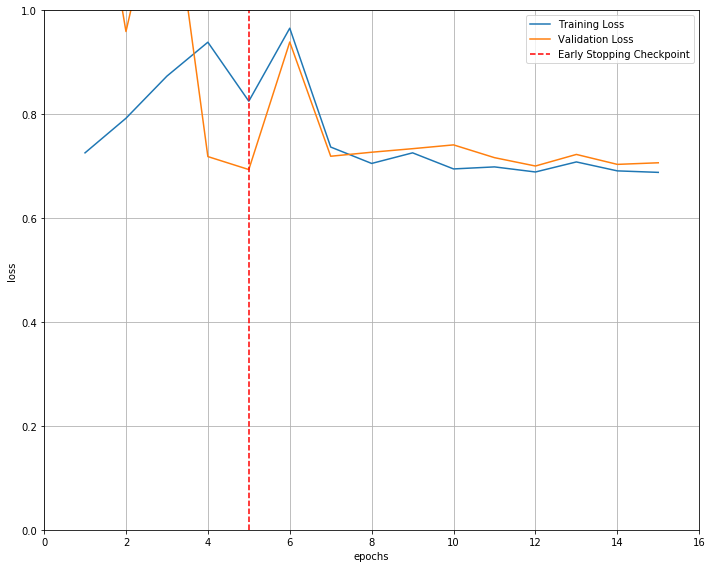

In [ ]:
# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

# find position of lowest validation loss
minposs = valid_loss.index(min(valid_loss))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 1.0) # consistent scale
plt.xlim(0, len(train_loss)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')

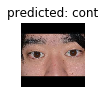

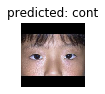

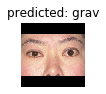

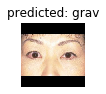

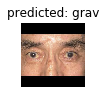

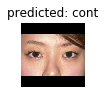

In [ ]:
visualize_model(model_ft)

In [ ]:
print(class_names) #labelsとの対応を確認

#Dataloaderをbatch size=1で再定義する
data_dir = '/content/data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=1,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}


total, label_positive, label_negative, TP, FP, TN, FN = [0]*7

with torch.no_grad():
    for data in dataloaders['val']:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_ft(inputs)
        _, predicted = torch.max(outputs.data, 1)

        total += 1

        if labels == 0:
            label_positive += 1
            if predicted == labels:
                TP += 1
            elif predicted != labels:
                FN += 1

        if labels == 1:
            label_negative += 1
            if predicted == labels:
                TN += 1
            elif predicted != labels:
                FP += 1   

accuracy = (TP + TN)/ (TP + TN + FP + FN)
precision  = TP/(FP + TP)
sensitivity = TP/(TP + FN)
specificity = TN/(FP + TN)
f_value = (2*sensitivity*precision)/(sensitivity+precision)

print('Samples = '+str(total))
print('label_positive = '+str(label_positive) +', '+'true_positive = '+str(TP))
print('label_negative = '+str(label_negative) +', '+'true_negative = '+str(TN))

print('accuracy = '+str(accuracy))
print('precision = '+str(precision))
print('sensitivity = '+str(sensitivity))
print('specificity = '+str(specificity))
print('f_value = '+str(f_value))

['cont', 'grav']
Samples = 130
label_positive = 65, true_positive = 30
label_negative = 65, true_negative = 41
accuracy = 0.5461538461538461
precision = 0.5555555555555556
sensitivity = 0.46153846153846156
specificity = 0.6307692307692307
f_value = 0.504201680672269


#固定された特徴抽出器としての ConvNet
ここで、最終層を除くネットワーク総てを凍結する必要があります。勾配が backward() で計算されないようにパラメータを凍結するために requires_grad == False を設定する必要があります。

In [ ]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

#訓練と評価
これは CPU 上で前のシナリオに比べておよそ半分の時間で済むでしょう。ネットワークの殆どに対して勾配が計算される必要がないためです。けれども、forward は計算される必要があります。

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, patience=5, num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.7169 Acc: 0.5371
val Loss: 0.6409 Acc: 0.6385
Validation loss decreased (inf --> 0.640896).  Saving model ...

Epoch 1/24
----------
train Loss: 0.6403 Acc: 0.6387
val Loss: 0.6971 Acc: 0.5615
EarlyStopping counter: 1 out of 5

Epoch 2/24
----------
train Loss: 0.6205 Acc: 0.6191
val Loss: 0.5932 Acc: 0.6538
Validation loss decreased (0.640896 --> 0.593230).  Saving model ...

Epoch 3/24
----------
train Loss: 0.6210 Acc: 0.6426
val Loss: 0.5900 Acc: 0.6769
Validation loss decreased (0.593230 --> 0.589977).  Saving model ...

Epoch 4/24
----------
train Loss: 0.5997 Acc: 0.6719
val Loss: 0.6424 Acc: 0.6077
EarlyStopping counter: 1 out of 5

Epoch 5/24
----------
train Loss: 0.5570 Acc: 0.7012
val Loss: 0.6804 Acc: 0.5923
EarlyStopping counter: 2 out of 5

Epoch 6/24
----------
train Loss: 0.5720 Acc: 0.6914
val Loss: 0.6077 Acc: 0.6692
EarlyStopping counter: 3 out of 5

Epoch 7/24
----------
train Loss: 0.5566 Acc: 0.6992
val Loss: 0.6252 Acc: 0.6692
EarlyStopping counter

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()

AttributeError: ignored